## Lecture 1

# Quantum Cloud, Near-Time Compute, and Qiskit Runtime
<br>
<br>

You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation22/tree/main

michele.grossi@cern.ch

## Introduction to Qiskit

Qiskit is a Python-based, open source software development toolkit (SDK) for working with quantum computers.  It can be used at the level of circuits, algorithms, and application modules.

### Installing Qiskit

Anaconda or a pyenv is recommended to manage all dependencies.

*Command:* `pip install qiskit`

*Python version:* 3.6+


### Typical Qiskit Workflow

**Build**: Design a quantum circuit(s) that represents the problem you are considering.

**Compile**: Compile circuits for a specific quantum backend, e.g., a quantum system or classical simulator.

**Run**: Run the compiled circuits on the specified quantum backend.

**Analyze**: Compute summary statistics and visualize the results of the experiments.


### Step 0 : check package version

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

#### Step 1: Build the Circuit

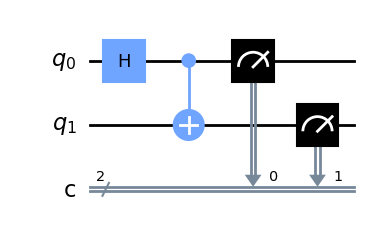

In [2]:
from qiskit import QuantumCircuit

# Create a quantum circuit with 2 qubits and 2 classical bits
circuit = QuantumCircuit(2, 2)

# Add a Hadamard gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Measure qubits 0 and 1 onto classical bits 0 and 1
circuit.measure([0, 1], [0, 1])

# Draw the circuit
circuit.draw('mpl')

#### Step 1 bis: visualize the matrix generated by the circuit

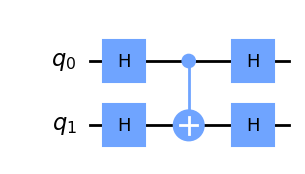

<IPython.core.display.Latex object>

In [3]:
from qiskit import assemble, Aer
from qiskit.visualization import array_to_latex

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.h(0)
qc.h(1)
display(qc.draw('mpl')) 

qc.save_unitary()
usim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()
array_to_latex(unitary, prefix="\\text{Circuit = }\n")

#### Step 2: Compile the Circuit

In [4]:
from qiskit import transpile
from qiskit.providers.aer import AerSimulator

# Use a local simulator
simulator = AerSimulator()

# Compile the circuit down to low-level instructions supported by the backend
compiled_circuit = transpile(circuit, simulator)


/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


#### Step 3: Run the Circuit

In [5]:
# Execute the circuit on the qasm simulator
# shots defines the number of executions
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

#### Step 4: Analyze and Visualize the Result

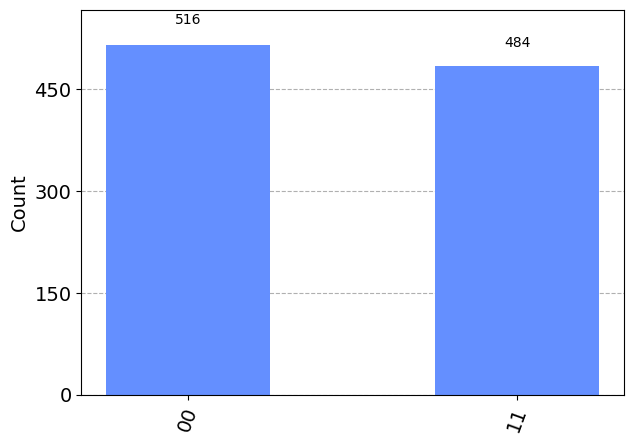

In [6]:
from qiskit.visualization import plot_histogram

# Get summarized counts of qubit measurements
counts = result.get_counts()

# Plot a histogram
# "00" means both qubits were measured 0; "11" means both were measured 1.
plot_histogram(counts)

### Extra: some additional functions

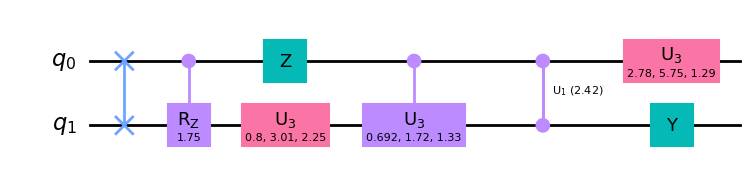

In [7]:
#Import the random circuit class
from qiskit.circuit.random import random_circuit
#Create two random circuits, each with 2 qubit registers and random #gate operator counts.
qc1 = random_circuit(2,2)
qc2 = random_circuit(2,4)
#Concatenate the two random circuits
qc = qc1.compose(qc2)
#Draw the circuit
qc.draw('mpl')

In [ ]:
#Define function to print circuit properties:
def print_circuit_props(qc):
    width = qc.width()
    depth = qc.depth()
    num_operators = qc.count_ops()
    circuit_size = qc.size()
    print('Width = ',width) 
    print('Depth = ', depth)
    print('Circuit size = ',circuit_size)
    print('Number of operators = ', num_operators)

In [ ]:
#Pass our quantum circuit to print out the circuit properties
print_circuit_props(qc)

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
#Print out the circuit properties
print_circuit_props(qc)
qc.draw('mpl')

In [ ]:
qc.decompose().draw('mpl')

In [ ]:
#Print out the circuit properties
print_circuit_props(qc.decompose())

In [ ]:
from qiskit import QuantumRegister
#Create a custom two-qubit composite gate
#Create the quantum register
qr = QuantumRegister(2, name='qr_c')
#Generate quantum circuit which will make up the composite gate
comp_qc = QuantumCircuit(qr, name='my-composite')
#Add any gates you wish to your composite gate
comp_qc.h(0)
comp_qc.cx(0, 1)
#Create the composite instructions by converting 
#the QuantumCircuit to a list of Instructions
composite_inst = comp_qc.to_instruction()
#Draw the circuit which will represent the composite gate
comp_qc.draw('mpl')

In [ ]:
#Create another 3-qubit circuit 
qr2 = QuantumRegister(3, 'qr')
#Create a quantum circuit using the quantum register
qc = QuantumCircuit(qr2)
#Add any arbitrary gates that would represent the function 
#of the composite gate 
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
#Draw the composite circuit
qc.draw('mpl')

In [ ]:
#Append your composite gate to the specified qubits. 
qc.append(composite_inst, [qr2[0], qr2[1]])
#Draw the complete circuit
qc.draw('mpl')

## Parameterized circuits

In [ ]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)


In [ ]:
qc.draw('mpl')

### Binding parameters to values
All circuit parameters must be bound before sending the circuit to a backend. This can be done as follows:
- The `bind_parameters` method accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported, in which case the returned circuit will be parameterized by any `Parameter`s that were not mapped to a value.

In [ ]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

In [ ]:
circuits[-1].draw('mpl')

In [ ]:
from qiskit import BasicAer, transpile
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

In the example circuit, we apply a global $R_z(\theta)$ rotation on a five-qubit entangled state, and so expect to see oscillation in qubit-0 at $5\theta$.

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

NB To insert a subcircuit under a different parameterization, the `to_instruction` method accepts an optional argument (`parameter_map`) which, when present, will generate instructions with the source parameter replaced by a new parameter.

In [ ]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])

In [ ]:
print(larger_qc.draw())

In [ ]:
print(larger_qc.decompose().draw())

### Extra about visualization

In [ ]:
# Will execute the circuit on the state vector (sv) simulator
# Returns state vector results, circuit diagram, and Bloch sphere 
from qiskit import Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
def execute_circuit_sv(quantum_circuit):
    #Create a state vector simulator
    statevector_simulator = Aer.get_backend('statevector_simulator')
    #Execute the circuit on the simulator
    result = execute(quantum_circuit, statevector_simulator).result()
    #Assign state vector results
    statevector_results  = result.get_statevector(quantum_circuit)
    #Draw the circuit diagram
    circuit_diagram = quantum_circuit.draw('mpl')
    #Draw the Bloch sphere result
    q_sphere = plot_state_qsphere(statevector_results)
    #Return the results, circuit diagram, and Bloch sphere
    return statevector_results, circuit_diagram, q_sphere

In [ ]:
#H-gate 
#Create the single qubit circuit
qc = QuantumCircuit(1)
#Add an H gate to the qubit
qc.h(0)
#Execute the circuit and capture all the results
result, img, qsphere  = execute_circuit_sv(qc)

In [ ]:
qsphere

In [ ]:
#U3-gate
from math import pi
#Create a single qubit circuit
qc = QuantumCircuit(1)
#Add a U3 gate and rotate all parameters by pi/2, and apply it to the qubit
qc.u(pi/2, pi/2, pi/2, 0)
#Execute the circuit and capture all the results
result, img, qsphere = execute_circuit_sv(qc)

In [ ]:
qsphere

## Introduction to IBM Quantum

Offers access to cloud-based quantum computing services

- quantum processors
- simulators
- experiments
- tutorials
- **runtime**

### Using Qiskit to access IBM Quantum services

Qiskit is designed to work with different providers. A _provider_ is any entity that provides quantum-related services that can be accessed using Qiskit. The most common service is quantum processors. `AQT`, `Honeywell`, and `IBM` are example of companies that provide access to their quantum processors through Qiskit.

Since `Runtime` is currently an IBM-only service, this tutorial will focus on using IBM Quantum services.

Before you can access IBM Quantum services, you need an IBM Quantum account. You can sign up for an account at https://quantum-computing.ibm.com/.

Once you have an account, you can grab your API token

<img src="images/token.png">

#### Initializing Your Account in Qiskit

In [ ]:
# Import the module needed to access IBM Quantum
from qiskit import IBMQ

# Load your IBM Quantum account or enable the account if it's not previously saved.
provider   = IBMQ.load_account()
#provider = IBMQ.enable_account('APIKEY')

IBM Quantum provider uses the syntax:

```
provider.SERVICE.METHOD()
```

where SERVICE might be one of {backend, runtime, primitive}

- Use `provider.backend` to target a quantum processor or simulator for running circuits
- Use `provider.runtime` to target a higher level runtime program and to define a job as a collection of iterative calls to the quantum computer. When you start a session, it caches the data you send so it doesn’t have to be transmitted to the Quantum Datacenter on each iteration.

For more details please have a look [here](https://research.ibm.com/blog/qiskit-runtime-for-useful-quantum-computing) and [tutorial](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html)

#### Running a Circuit on IBM Quantum Backend and Transpiling

In [ ]:
provider.backends()

In [ ]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In [ ]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

circuit = QuantumCircuit(7)
circuit.h(3)
circuit.cx(0, 6)
circuit.cx(6, 0)
circuit.cx(0, 1)
circuit.cx(3, 1)
circuit.cx(3, 0)

coupling_map = CouplingMap(couplinglist=coupling)

bs = BasicSwap(coupling_map=coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map=coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map=coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

In [ ]:
circuit.draw(output='mpl')

In [ ]:
lookahead_circ.draw(output='mpl')

In [ ]:
import math
qiskit.providers.fake_provider

backend = FakeTokyo()  

In [ ]:
optimized_0 = transpile(circuit, backend=backend, seed_transpiler=11, optimization_level=0)

In [ ]:
optimized_0.draw('mpl')

In [ ]:
qc = random_circuit(3,2)
qc.measure_all()

In [ ]:
# Select a backend to run the circuit
backend = provider.backend.ibmq_qasm_simulator

result = backend.run(transpile(qc, backend), shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

In [ ]:
# Plot the result
plot_histogram(counts, color='green', title="New Histogram")

### Hands-on part

#### Try yourself

The goal is to reach the state $|-\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$. 

<div><img src="images/minus.png" width="200"></div>

In [ ]:
## Insert your code here
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram



### Solution

In [2]:
#INSERT CODE HERE

## Some exercises on Bell states

Construct the Bell state $|\Psi^+\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle + |10\rangle\right)$.

In [ ]:
## CHECK THE RESULT
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
display(array_to_latex(Statevector.from_instruction(qc), prefix="\\text{Statevector} = "))

### Solution

In [4]:
qc = QuantumCircuit(2,2) # this time, we not only want two qubits, but also two classical bits for the measurement
#INSERT CODE HERE

Construct the other Bell states:

- $|\Psi^-\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - |10\rangle\right)$ 
- $|\Phi^+\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right)$
- $|\Phi^+\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle - |11\rangle\right)$ 

Write a function that builds a quantum circuit on 3 qubits and creates the GHZ-like state, $|\Psi\rangle = \frac{1}{\sqrt{2}} \left(|010\rangle - |101 \rangle \right)$.

Hint: start from the circuit that constructs the GHZ state, $|GHZ\rangle = \frac{1}{\sqrt{2}} \left(|000\rangle + |111 \rangle \right)$:

In [ ]:
## WRITE YOUR CODE HERE:
#
#
#
#


backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
counts = execute(qc, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
counts

## Exercise

Consider the following quantum circuit
<img src="images/inverse.png" width="500" height="340">

- Calculate the matrix of the unitary operation U corresponding to C, with respect to the computational basis.
- Write down a quantum circuit corresponding to the inverse operation $U^{-1}$
- If C is applied to the initial state $|0⟩|0⟩$ and is followed by a measurement of each qubit in the computational basis, what is the distribution on measurement outcomes?

### Solution

In [ ]:
## WRITE YOUR CODE/calculation HERE:
#
#
#
#

In [ ]:
# inverse circuit


#BONUS VISUALIZATION
gate_colours = {
    "displaycolor": {
        "x": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "h": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "cx": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "ry": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}

display(qci.draw('mpl',style=gate_colours)) 



## Overview of Quantum States

State-vector notation  is convenient when dealing with states that can always be expressed as a linear combination of basis states, each with an associated probability amplitude. The definition of the state of our qubits cannot always be written down as linear combinations in a given basis, sometimes it must be expressed in terms of ensembles (statistical mixtures) of multiple states (noise), each with an associated probability of occurrence. The adopted formulation is the `density matrix`. 
In the following we will review this formulation for ***pure state***, **mixed state** and we introduce the concept of **state purity** and ***partial trace***.

#### Pure State
Pure states are those for which we can precisely define their quantum state at every point in time and the measurement outcome will be probabilistic with no uncertainty on what this quantum state will be.
For example, if we initialize the single qubit $|q \rangle $ in state $ | 0 \rangle $, and apply a Hadamard gate, we know our final state will be:

$$ 
| q \rangle = \frac{1}{\sqrt{2}} \left( | 0 \rangle  + | 1 \rangle  \right) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = | + \rangle 
$$
In general, we know that in the conventional state vector notation, an $n$-qubit pure state can be expressed as:

$$ | \psi \rangle = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_{N-1} \end{bmatrix}, $$

where $ N = 2^{n} $. An alternative way to express this pure quantum state is in the form of a matrix. This can be done by using the density operator representation, which is defined as:

$$ \rho \equiv  | \psi \rangle \langle \psi | $$

Here, the term $| \psi \rangle \langle \psi | $ represents the [outer product](../ch-gates/proving-universality.ipynb#outer) of the state $ \psi $ with itself:


$$ 
\begin{aligned}
& \rho = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_N \end{bmatrix} \begin{bmatrix} \alpha_0^* & \alpha_1^* & \dots & \alpha_N^* \end{bmatrix} 
\\
\\
& \rho = \begin{bmatrix} |\alpha_0|^2 & \alpha_0 \alpha_1^* & \dots & \alpha_0 \alpha_N^* \\ \alpha_1 \alpha_0^* & |\alpha_1|^2 & \dots & \alpha_1 \alpha_N^* \\ \vdots & \vdots & \ddots & \vdots \\ \alpha_N \alpha_0^* & \alpha_N \alpha_1^* & \dots & |\alpha_N|^2 \end{bmatrix}
\end{aligned}
$$


Let's consider, for example, the following two-qubit, maximally-entangled pure state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0 0 \rangle + | 1 1 \rangle \right ) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} 
$$


The density matrix representation for this state is then given by:

$$ 
\begin{aligned}
& \rho_{AB}  = | \psi_{AB} \rangle \langle \psi_{AB} |
\\
\\
& \rho_{AB} = \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} \right ) \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix} \right )
\\
\\
& \rho_{AB} = \frac{1}{2} \begin{bmatrix} 1 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 1 \\ \end{bmatrix}
\end{aligned}
$$


In Qiskit, we can use the ``quantum_info`` module to represent quantum states either in state vector notation, or in the density matrix representation. For convenience, we will import this module as ``qi``:

In [8]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

Let's once again consider the entangled pure state $| \psi_{AB} \rangle $. We can prepare this state by applying a Hadamard gate to the first qubit, and an CNOT between the first and second qubits:

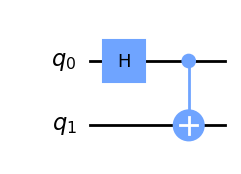

In [9]:
qc_AB = QuantumCircuit(2)
qc_AB.h(0)
qc_AB.cx(0,1)
qc_AB.draw('mpl')

To obtain the state constructed by our ``QuantumCircuit`` in state vector notation, we can make use of the ``Statevector.from_instruction()`` class method from the ``quantum_info`` module as follows:

In [10]:
psi_AB = qi.Statevector.from_instruction(qc_AB)
psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')

<IPython.core.display.Latex object>

Similarly, we can use the ``DensityMatrix.from_instruction()`` class method to obtain density matrix representation for this same state:

In [11]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')

<IPython.core.display.Latex object>

As expected, the result matches our calculation. We can also visualize the density matrix using a cityscape plot of the state:

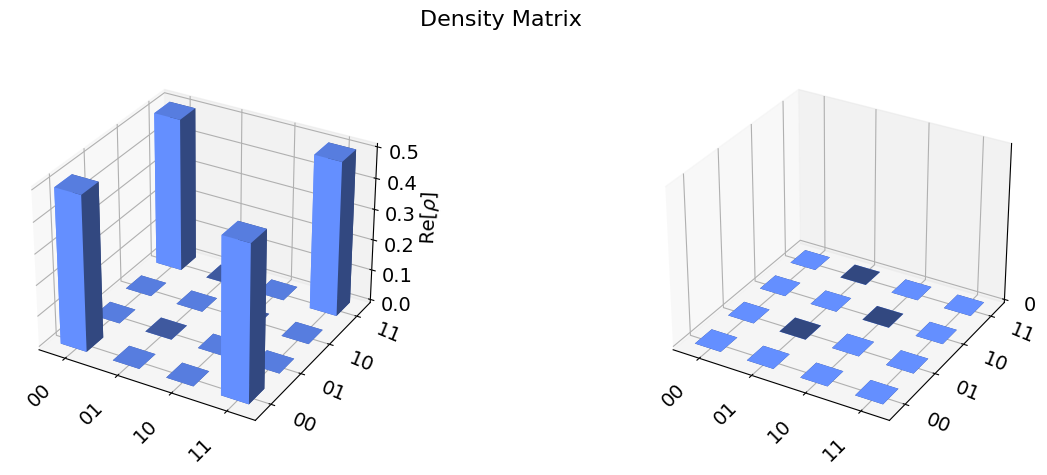

In [12]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_AB.data, title='Density Matrix')

### 1. Exercises  <a id="ex1"></a>
Find the corresponding density matrix for the following pure states. Use Qiskit to prepare the states, and verify your results using the ``quantum_info`` module:
   
1.	$ \frac{1}{2}\left ( |0 0 \rangle + |0 1 \rangle + |1 0 \rangle + |1 1 \rangle \right ) $       



Now, all we have done so far is show a different way to represent quantum states, but there is no apparent advantage in doing so. To understand why the density matrix representation is beneficial, we need to learn about the concept of mixed states.

## 2. Mixed States <a id="mixed"></a>

Mixed states are those that consist of statistical ensembles of different quantum states.

Consider, once again, the two-qubit entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$

Here we have explicitly used the subscripts $A$ and $B$ to label the qubits associated with registers $q_1$ and $q_0$, respectively. Now, let's assume that right after preparing our state $| \psi_{AB} \rangle $ we perform a measurement on register $q_1$.


We know that after a measurement, $\psi_B$ will be in state $| 0_B \rangle $ with probability $1/2$, or in state $| 1_B \rangle $ with probability $1/2$; however, $\psi_B$ is **not** in a linear superposition of $| 0_B \rangle $ and $| 1_B \rangle $. In other words, $\psi_B$ **cannot** be expressed as a state vector of the form $1/\sqrt{2} \left (|0_B \rangle + | 1_B \rangle \right)$. Instead, we have to use a different notation to write down that $\psi_B$ is rather an ensemble (not a quantum superposition) of the states $| 0_B \rangle $ and $| 1_B \rangle $, and whose outcome depends on what we measure on register $q_1$. 

We then call $\psi_B$ a mixed state, which can be represented as an ensemble of states:

$$
\left \{| \psi_{B_0} \rangle , | \psi_{B_1} \rangle \right \} = \left \{ | 0_B \rangle , | 1_B \rangle \right \},
$$ 

each with an associated probability of occurrence:

$$ \left \{ p_0, p_1 \right \} = \left \{ 1/2, 1/2 \right \} $$

Although this way of expressing $\psi_B$ (or any general mixed state) is perfectly valid, it turns out to be somewhat inconvenient. Since a mixed state can consist of a myriad of pure states, it can be difficult to track how the whole ensemble evolves when, for example, gates are applied to it. It is here that we turn to the density matrix representation.

A mixed state, consisting of several possible outcome pure states $|\psi_j \rangle$ , each with probability of occurrence $p_j$, is defined as a density matrix of the form:

$$ \rho \equiv \sum_{j} p_j |\psi_j \rangle \langle \psi_j | $$

It is easy to see that this general definition of the density matrix also holds for pure states, for which we will only have one $ |\psi_j \rangle $ term with $p_j = 1$.

### State Purity <a id="trace_sqr"></a>

A very useful property of the density matrix is that when taking the trace $\text{Tr}$ of its square $\rho^{2}$, we obtain a scalar value $\gamma$ that is good measure of the purity of the state the matrix represents. For normalized states, this value is always less than or equal to 1, with the equality occurring for the case of a pure state:

$$ \gamma \equiv \text{Tr}(\rho^{2}) \leq 1 $$

$$ \gamma \equiv \text{Tr}(\rho^{2}) = 1 \; \text{if pure} $$

In Qiskit, we can easily extract the purity of a density matrix by using the `purity()` class method. For example, for the pure state $| + \rangle$, we should expect to see a purity of 1:

In [14]:
import numpy as np
rho_p = qi.DensityMatrix.from_label('+')
display(rho_p.draw('latex', prefix='\\rho_p = '))
gamma_p = rho_p.purity()
print("State purity: ", np.round(np.real(gamma_p),3))

<IPython.core.display.Latex object>

State purity:  1.0


And, for a mixed state, like $\rho_m = \frac{1}{2} | 0 \rangle \langle 0 | + \frac{1}{2} | 1 \rangle \langle 1 | $, we expect a purity of less than 1:

In [15]:
rho_m = 1/2*(qi.DensityMatrix.from_label('0') + qi.DensityMatrix.from_label('1'))
display(rho_m.draw('latex', prefix='\\rho_m = '))
gamma_m = rho_m.purity()
print("State purity: ", np.round(np.real(gamma_m),3))

<IPython.core.display.Latex object>

State purity:  0.5


***NB*** One of the drawbacks of representing the density matrices in terms of ensembles of basis states, is that their outcome is not unique. Understanding that the same density matrix can represent many different ensembles of quantum states is important to avoid drawing conclusions about a particular system simply based on its density matrix representation alone. 

### The Reduced Density Matrix
When working with the density matrix notation on composite systems, we can extract the state of each subsystem, even if they are entangled. This is done in the form of what is known as the reduced density matrix.

Consider a quantum system composed of subsystems $A$ and $B$, and fully described by the density matrix $\rho_{AB}$. The reduced density matrix of subsystem $A$ is then given by:

$$ \rho_{A} = \text{Tr}_B(\rho_{AB}), $$


Here, $\text{Tr}_B$ is an operation known as the partial trace, which is defined as: 

$$
\text{Tr}_B \left (| \xi_u \rangle \langle \xi_v | \otimes | \chi_u \rangle \langle \chi_v | \right ) \equiv | \xi_u \rangle \langle \xi_v | \text{ Tr} \left ( | \chi_u \rangle \langle \chi_v | \right )
$$

$| \xi_u \rangle $ and $| \xi_v \rangle $ are arbitrary states in the subspace of $A$, and $| \chi_u \rangle $ and $| \chi_v \rangle $ arbitrary states in the subspace of $B$. $\text{Tr}$ is the standard trace operation, which for two arbitrary states $\text{Tr} \left ( | \chi_u \rangle \langle \chi_v | \right ) = \langle \chi_v |\chi_u \rangle $. Similarly, we can calculate the reduced density matrix of subsystem $B$ using the partial trace over $A$.

As an example, let's reconsider the pure entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$




This system is then composed of single-qubit subsystem $A$ with basis vectors $ \left \{ |\xi_1 \rangle, |\xi_2 \rangle \right \} = \{ | 0_A \rangle, | 1_A \rangle \}$, and single-qubit subsystem $B$ with basis vectors $ \left \{ |\chi_1 \rangle, |\chi_2 \rangle \right \} = \{ | 0_B \rangle, | 1_B \rangle \}$. We know that this system is not separable (i.e., $| \chi_{AB} \rangle \neq |\chi_{A}\rangle \otimes |\chi_{B}\rangle$); however, by using the reduced density matrix, we can find a full description for subsystems $A$ and $B$ as follows.

The density matrix of our state $| \psi_{AB} \rangle$ can be expressed in terms of outer products of the basis vectors as:

$$
\rho_{AB} = | \psi_{AB} \rangle \langle \psi_{AB} | =  \frac{1}{2} \left [ | 0_A 0_B \rangle \langle 0_A 0_B | + | 0_A 0_B \rangle \langle 1_A 1_B | + | 1_A 1_B \rangle \langle 0_A 0_B | + | 1_A 1_B \rangle \langle 1_A 1_B | \right ]
$$


Now, to calculate the reduced density matrix for, let's say, subsystem $B$, we have:

$$
\begin{aligned}
\rho_{B} & = \text{Tr}_A(\rho_{AB})
\\
\\
& = \frac{1}{2}\left [ \text{Tr}_A(| 0_A 0_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 0_A 0_B \rangle \langle 1_A 1_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 1_A 1_B |) \right ]
\\
\\
& = \frac{1}{2}\left [ \text{Tr}(| 0_A \rangle \langle 0_A |)| 0_B \rangle \langle 0_B | + \text{Tr}(| 0_A \rangle \langle 1_A |)| 0_B \rangle \langle 1_B | + \text{Tr}(| 1_A \rangle \langle 0_A |) | 1_B \rangle \langle 0_B | + \text{Tr}(| 1_A \rangle \langle 1_A |) | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ \langle 0_A | 0_A \rangle | 0_B \rangle \langle 0_B | + \langle 1_A | 0_A \rangle | 0_B \rangle \langle 1_B | + \langle 0_A | 1_A \rangle | 1_B \rangle \langle 0_B | + \langle 1_A | 1_A \rangle | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ | 0_B \rangle \langle 0_B | + | 1_B \rangle \langle 1_B | \right ]
\\
\\
&= \frac{1}{2} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
\end{aligned}
$$



At first glance, this result might seem rather strange. We started with the pure entangled state $|\psi_{AB} \rangle $, and  calculated that the state of one of its parts (subsystem $B$) is the mixed state $\rho_{B}$. However, going back to the first example given above, we see that the result from calculating the reduced density matrix for $B$ is equivalent to the representation we obtained for $\psi_B$, when measurements were taken over qubit $A$. We can then conclude that the reduced density matrix $\rho_{B}$ is a way to describe the statistical outcomes of subsystem $B$, when the measurement outcomes of subsystem $A$ are averaged out. This is in fact what ”tracing out” subsystem $A$ means.

It is worth mentioning that so far we have described the concept of partial trace for a bipartite (two-part) system, but this can be generalized for multi-part systems.

In Qiskit, we can easily obtain the reduced density matrix of a system by using the ``partial_trace()`` function and passing the density matrix of the composite system, and a list with the subsystems to trace over:



In [16]:
rho_B = qi.partial_trace(rho_AB,[0])
rho_A = qi.partial_trace(rho_AB,[1])

display(rho_B.draw('latex', prefix=" \\rho_{B} = "),
        rho_A.draw('latex', prefix=" \\rho_{A} = "))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Exercises  <a id="ex4"></a>
Calculate the reduced density matrices for following:

The mixed state: $ \rho_{mr} = \frac{1}{4} | \Phi^+ \rangle \langle \Phi^+ | + \frac{3}{4} | \Phi^- \rangle \langle \Phi^- |$, where $| \Phi^+ \rangle$ and $| \Phi^- \rangle$ are the Bell states:

$| \Phi^+ \rangle = \frac{1}{\sqrt{2}} \left( |00 \rangle + |11 \rangle \right ) $

$| \Phi^- \rangle = \frac{1}{\sqrt{2}} \left( |00 \rangle - |11 \rangle \right ) $
    
    
    and for the following quantum circuit

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:163: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


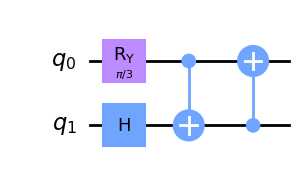

In [17]:
qc_CD = QuantumCircuit(2)
qc_CD.ry(np.pi/3,0)
qc_CD.h(1)
qc_CD.cx(0,1)
qc_CD.cx(1,0)
qc_CD.draw("mpl", style="iqx")

### Phase Kickback

<img src="images/phase_kickback.png" width="240" height="240" align="center"/>

1- Implement the circuit and visualize it to make sure it is correct.

2 - Obtain the final state using the state vector simulator and
visualize the state of the individual qubits on the Bloch sphere.
Which state did you obtain?

3 - Add an additional `CNOT` gate to the circuit.

4 - Execute it again the state vector simulator and the state of the
individual qubits on the Bloch sphere. What do you observe?


#### Optional tasks:
1 - Replace the CNOT gate in the circuit above with a controlled
Rx rotation.

2 - Simulate the circuit for various angles of the rotation gate and
visualize the results on the Bloch sphere. What do you
observe? Can you explain the effect?


These two circuits are special cases of **phase kickback**.

Phase kickback is a fundamental building block of many quantum algorithms.
General form is:

<img src="images/phase_kickback2.png" width="340" height="340" align="center"/>

Choosing $|u\rangle$ as an eigenstate of $U$ with eigenvalue $\exp(i\phi)$ we have:

- $|0\rangle \otimes |U\rangle \to H \to \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle) \otimes |u\rangle $ 
- $\frac{1}{\sqrt{2}}( |0\rangle + |1\rangle) \otimes |u\rangle  \to cU \to \frac{1}{\sqrt{2}}( |0\rangle \otimes |u\rangle+ \exp(i\phi)|1\rangle\otimes |u\rangle) $

$\longrightarrow$ Phase has been kicked back into the control qubit

- $\frac{1}{\sqrt{2}}( |0\rangle \otimes |u\rangle+ \exp(i\phi)|1\rangle\otimes |u\rangle) \to H \to (\cos\frac{\phi}{\sqrt{2}}|0\rangle)+ i\sin\frac{\phi}{\sqrt{2}}|1\rangle)\otimes |u\rangle$


Further reading on https://qiskit.org/textbook/ch-gates/phase-kickback.html

## HOMEWORK

### 1. Explaining the CNOT Circuit Identity <a id="explaining-identity"></a>
Let's lool at this identity:

![cnot_identity](images/identities_1.svg)

This is an example of _kickback_ (or, _phase kickback_ ) which is very important and is used in almost every quantum algorithm. Kickback is where the eigenvalue added by a gate to a qubit is ‘kicked back’ into a different qubit via a controlled operation. This identity is very useful in hardware, since some hardwares only allow for CNOTs in one direction between two specific qubits. We can use this identity to overcome this problem and allow CNOTs in both directions.

For example, we saw that performing an X-gate on a $|{-}\rangle$ qubit gives it the phase $-1$:
$$
X|{-}\rangle = -|{-}\rangle
$$

When our control qubit is in either $|0\rangle$ or $|1\rangle$, this phase affects the whole state, however it is a global phase and has no observable effects:

$$
\begin{aligned}
\text{CNOT}|{-}0\rangle & = |{-}\rangle \otimes |0\rangle \\
                        & = |{-}0\rangle \\
                        \quad & \\
\text{CNOT}|{-}1\rangle & = X|{-}\rangle \otimes |1\rangle \\
                        & = -|{-}\rangle \otimes |1\rangle \\
                        & = -|{-}1\rangle \\
\end{aligned}
$$

The interesting effect is when our control qubit is in superposition...

#### Try to complete this initial proof.

## 2. Entanglement Tests


- Create the following circuit (add swap gates in the end to have the usual order of the qubits in read out)
<center><img src="images/circuito_esonero.png" width="500"/></center>
<center>Circuit proposed in the first internal test.</center>

In [ ]:
from qiskit import *
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import partial_trace, entropy

import numpy as np
import math

In [ ]:
nQubits = # <--- insert your code here
nClassicBits = 4

circuit.draw(output='mpl')

#### Calculate the overall output state

The order of the 4-qubits state follows the decimal notation:

<center><img src="images/Decimal_notation1.jpeg" width="700"/></center>

In the case of 4 qubits we then have the states ordered as follow:

<center><img src="images/Decimal_notation2.jpeg" width="800"/> </center

In [ ]:
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend = # <--- insert your code here

outputstate = # <--- insert your code here
print(outputstate)

Now print the amplitudes and compare them with the calculated output state:
<center><img src="images/psi_out.jpeg" width="600"/></center>

In [ ]:
list_check = [5,7,8,10]
for ind in list_check:
    print(outputstate[ind])

#### Plot the final state using the Bloch and the Q-sphere 

#### Is AB entangled with CD? 
Calculate the reduced density matrix $\rho_{CD}$ anche check if the `Von Neumann entropy` is equal or greater than zero.

We can do this using the previous result of the output state and the Qiskit's **partial_trace(state, list_qubits_to_be_traced_out)** module, that let us calculate reduced matrices.

We can also use the Qiskit's `entropy(rho_matrix)` module to calculate the Von Neumann entropy. See https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/quantum_info/states/measures.py for more details.

In [ ]:
def check_vn_entropy(vn_entropy):
    if vn_entropy != 0.:
        print("The state is a mixed state")

In [ ]:
## insert your code here -->
check_vn_entropy(my_entropy)